<a href="https://colab.research.google.com/github/NguyenThiHongLinh/TieuLuan2024/blob/main/Ti%E1%BB%83u_lu%E1%BA%ADn_Beijing2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kết nối với drive, import thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Data tiểu luận'
! pip install pypots>=0.4

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data tiểu luận


In [ ]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from prettytable import PrettyTable
from numpy import mean
from numpy import std
# import miceforest as mf
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
# from pypots.data import load_specific_dataset, mcar, masked_fill
import torch
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.optim import Adam
from pypots.imputation import BRITS
from pypots.imputation import MRNN
from pypots.imputation import Transformer
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_mse
from pypots.utils.metrics import calc_rmse

In [ ]:
dtype = {
    "PM2.5": float,
    "PM10": float,
    "SO2": float,
    "NO2": float,
    "CO": float,
    "O3": float,
    "TEMP": float,
    "PRES": float,
    "DEWP": float,
    "RAIN": float,
    "wd": float,
    "WSPM": float,
    "station": str
}


def clean_data(elem):
    elem = str(elem)
    if elem == None or elem == '':
        return np.NaN
    if any(x in elem for x in ["#", "*", "x"]):
        return np.NaN
    if any(x in elem for x in [".", "e"]):
        return float(elem)
    if elem in 'NR':
        return -1
    return int(elem)

converters = {
    "PM2.5": clean_data,
    "PM10": clean_data,
    "SO2": clean_data,
    "NO2": clean_data,
    "CO": clean_data,
    "O3": clean_data,
    "TEMP": clean_data,
    "PRES": clean_data,
    "DEWP": clean_data,
    "RAIN": clean_data,
    "wd": clean_data,
    "WSPM": clean_data,
}

## Load dataset, tính toán % dữ liệu bị thiếu

In [ ]:
def load_beijing():
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
  dataset['time'] = pd.to_datetime(dataset['time'])
  return dataset

In [ ]:
# Compute % missing rate of a given dataset (as a DataFrame)
def missing_rate(dataset):
  total_missing = dataset.isnull().sum().sum()
  percent_missing = (total_missing / dataset.size) * 100
  return round(percent_missing,2)

## Tiền xử lý dữ liệu

In [ ]:
def preprocess_beijing(dataset):
    """The preprocessing function for dataset Air Quality Taiwan 2015.
    Parameters
    ----------
    dataset : raw dataset loaded from csv file.
    Returns
    -------
    dataset : pandas.DataFrame,
                A dataframe contains all time series vectors, distinguished by column 'station'.
    """
    print('Columns:', dataset.columns)

    # Giả sử dữ liệu ngày tháng nằm trong cột 'time', tách ngày và giờ
    if 'time' in dataset.columns:
        dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        dataset['hour'] = pd.to_datetime(dataset['time']).dt.hour
    else:
        raise KeyError("'time' column not found in dataset")

    X = dataset
    print('X shape: ', X.shape)
    def apply_func(df_temp):  # pad and truncate to set the max length of samples as 24
        missing = list(set(range(0, 24)).difference(set(df_temp['hour'])))
        print('DF_TEMP', df_temp.shape)
        missing_part = pd.DataFrame({'hour': missing})
        df_temp = pd.concat(
            [df_temp, missing_part], ignore_index=False, sort=False
        )  # pad the sample's length to 24 if it doesn't have enough time steps
        df_temp = df_temp.set_index('time').sort_index().reset_index()
        df_temp = df_temp.iloc[:24]  # truncate
        return df_temp

    X = X.groupby(['station', 'date']).apply(apply_func)
    X = X.drop('hour', axis=1)
    X = X.drop('station', axis=1)
    X = X.drop('date', axis=1)
    X = X.reset_index()
    X = X.drop(["level_2"], axis=1)
    return X

## Biểu diễn dữ liệu bị thiếu

In [ ]:
def display_missing_percent(dataset):
  total = dataset.isnull().sum().sort_values(ascending=False)
  percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  # plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of missing values', fontsize=15)
  plt.title('Percent missing data by feature', fontsize=15)
  missing_data.head

## Lọc và sắp xếp các bản ghi theo từng khu vực

In [ ]:
def get_stat_by_station(dataset):
  myTable = PrettyTable(["No.","station","#Records","From date","To date"])
  # Split dataframe by RecordID
  j = 1
  classification=list(dataset['station'].unique())
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    myTable.add_row([j,
                     i,
                    format(pm1.shape[0], ','),
                    pm1['time'].values[0],
                    pm1['time'].values[pm1.shape[0]-1]])
  j+=1
  return myTable

## Biểu đồ phân phối tần suất thời gian

In [ ]:
# Danh sách các bộ dữ liệu và tên của chúng
def timeGraph(dataset):

# Khởi tạo figure
  plt.figure(figsize=(10, 6))

  # Lặp qua từng bộ dữ liệu và tên
  for dataset, time_column in dataset:
      # Chuyển đổi cột thời gian sang định dạng datetime
      time_data = pd.to_datetime(dataset[time_column])
      # Trích xuất giờ từ các đối tượng datetime
      hours = [time.hour for time in time_data]
      # Vẽ biểu đồ histogram
      plt.hist(hours, bins=24, edgecolor='black', alpha=0.5, label=time_column)

  # Thiết lập tiêu đề và nhãn trục
  plt.xlabel('Giờ')
  plt.ylabel('Số lượng')
  plt.title('Phân phối tần suất của dữ liệu thời gian')
  plt.xticks(range(0, 24))
  plt.grid(True)
  plt.legend()  # Hiển thị chú thích về tên của mỗi bộ dữ liệu
  plt.show()

In [ ]:
def find_time_steps(data):
  all_hours = set(range(24))

  # Lấy dữ liệu thời gian trong cột thời gian
  column_datetime1 =data['time']

  # Tính toán khoảng cách thời gian giữa các timestamp liên tiếp
  time_diffs = column_datetime1.diff().dt.total_seconds().dropna()

  # Tìm chu kỳ thời gian
  cycle_seconds = time_diffs.mode().iloc[0]

  print("The cycle duration appears to be approximately", cycle_seconds, "seconds.")


  # Xác định xem thời gian được ghi lại trong 24 giờ hay 12 giờ
  time_difference = (column_datetime1.iloc[-1] - column_datetime1.iloc[0]).total_seconds()

  # Determine if it's a 12-hour cycle or 24-hour cycle
  if time_difference > 12 * 3600:  # 12 hours * 3600 seconds/hour
      print("The time cycle appears to be 24 hours.")
  else:
      print("The time cycle appears to be 12 hours.")


  # Trích xuất giờ từ cột thời gian
  hours_in_column = set(column_datetime1.dt.hour)

  # Tìm giờ thiếu bằng cách lấy phần tử khác biệt giữa tập hợp tất cả các giờ và tập hợp giờ xuất hiện trong cột datetime
  missing_hours = all_hours - hours_in_column

  if missing_hours:
      print("Có các giờ sau thiếu:", missing_hours)
  else:
      print("Không có giờ nào thiếu.")



## Tính trend, cycle của dữ liệu

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Tính trend của tập dữ liệu khi loại bỏ các giá trị bị thiếu
def calculate_trend(data):
    # Xử lý giá trị NaN: Loại bỏ các dòng chứa giá trị NaN
    data_cleaned = data.dropna()

    # Loại bỏ các cột không cần thiết nếu tồn tại
    for col in ['time', 'station', 'Unnamed: 0', 'date']:
        if col in data_cleaned.columns:
            data_cleaned = data_cleaned.drop([col], axis=1)

    column_names = list(data_cleaned.columns)
    num_subplots = len(column_names)  # Số lượng subplot bằng số cột dữ liệu

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

    # Vẽ biểu đồ dữ liệu và đường trend cho từng thuộc tính
    for idx, col in enumerate(column_names):
        X = np.array(range(len(data_cleaned))).reshape(-1, 1)
        y = data_cleaned[col].values.reshape(-1, 1)

        # Khởi tạo và fit mô hình hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X, y)

        # Vẽ dữ liệu
        axes[idx].plot(data_cleaned[col], label=col)
        # Vẽ trend line
        axes[idx].plot(model.predict(X), label=f'Trend of {col}', linestyle='--')

        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Trend of {col}')
        axes[idx].legend(loc="best")

    plt.tight_layout()  # Đảm bảo không gian giữa các subplot
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def find_cycle(data, column, lags=50):
    """
    Hàm tính chu kỳ của dữ liệu chuỗi thời gian dựa trên hàm tự tương quan (ACF).

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    column : str
        Tên cột chứa dữ liệu chuỗi thời gian cần tính chu kỳ.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycle : int
        Chu kỳ của dữ liệu chuỗi thời gian.
    """
    # Xóa các giá trị thiếu
    data_cleaned = data.dropna(subset=[column])

    # Tính toán ACF
    acf_values = acf(data_cleaned[column], nlags=lags)

    # Tìm độ trễ (lag) tại đó ACF đạt cực đại (bỏ qua độ trễ 0)
    cycle = np.argmax(acf_values[1:]) + 1

    # Vẽ biểu đồ ACF để trực quan hóa
    plot_acf(data_cleaned[column], lags=lags)
    plt.title(f'Autocorrelation Function for {column}')
    plt.show()

    return cycle

def find_cycles_for_all_columns(data, lags=50):
    """
    Hàm tính chu kỳ cho tất cả các cột trong DataFrame.

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycles : dict
        Từ điển chứa chu kỳ của mỗi cột trong DataFrame.
    """
    cycles = {}
    for column in data.columns:
        if column == 'station' or not np.issubdtype(data[column].dtype, np.number):
            continue
        cycle = find_cycle(data, column, lags)
        cycles[column] = cycle
    return cycles

## Chuẩn bị dữ liệu bị thiếu nhân tạo

In [ ]:
from pygrinder import mcar, masked_fill
# def generate_artifical_missing(data, missing_rate):
#   X = data.copy()
#   X_intact, X, missing_mask, indicating_mask = mcar(X, missing_rate) # hold out 10-80% observed values as ground truth
#   X = masked_fill(X, 1 - missing_mask, np.nan)
#   return X_intact, X, missing_mask, indicating_mask
def generate_artifical_missing(data, missing_rate):
    X_intact = data.copy()
    missing_mask = np.random.rand(*data.shape) < missing_rate
    indicating_mask = np.random.rand(*data.shape) < missing_rate
    data[missing_mask] = np.nan
    return X_intact, data, missing_mask, indicating_mask

In [ ]:
# def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
#     # Ensure 'date' column exists
#     if 'date' not in train_data.columns:
#         if 'time' in train_data.columns:
#             train_data['date'] = pd.to_datetime(train_data['time']).dt.date
#             val_data['date'] = pd.to_datetime(val_data['time']).dt.date
#             test_data['date'] = pd.to_datetime(test_data['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the data.")

#     num_samples = int(len(train_data['date']) / n_steps)

#     # Drop 'date' and 'station' columns
#     train_X = train_data.drop(['date', 'station'], axis=1)
#     val_X = val_data.drop(['date', 'station'], axis=1)
#     test_X = test_data.drop(['date', 'station'], axis=1)

#     train_X, val_X, test_X = (
#         train_X.to_numpy(),
#         val_X.to_numpy(),
#         test_X.to_numpy(),
#     )

#     # Normalize the data
#     scaler = StandardScaler()
#     train_X = scaler.fit_transform(train_X)
#     val_X = scaler.transform(val_X)
#     test_X = scaler.transform(test_X)

#     train_X = train_X.reshape(num_samples, n_steps, -1)
#     val_X = val_X.reshape(int(len(val_data['date']) / n_steps), n_steps, -1)
#     test_X = test_X.reshape(int(len(test_data['date']) / n_steps), n_steps, -1)

#     # Generate artificial missing data
#     val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
#     test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

#     data = {
#         "n_steps": n_steps,
#         "n_features": train_X.shape[-1],
#         "train_X": train_X,
#         "val_X": val_X,
#         "test_X": test_X,
#         "scaler": scaler,
#         "val_X_intact": val_X_intact,
#         "val_X_indicating_mask": val_X_indicating_mask,
#         "test_X_intact": test_X_intact,
#         "test_X_indicating_mask": test_X_indicating_mask,
#     }

#     return data

def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
    # Ensure 'date' column exists
    if 'date' not in train_data.columns:
        if 'time' in train_data.columns:
            train_data['date'] = pd.to_datetime(train_data['time']).dt.date
            val_data['date'] = pd.to_datetime(val_data['time']).dt.date
            test_data['date'] = pd.to_datetime(test_data['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the data.")

    # Drop 'date', 'station' and 'time' columns
    train_X = train_data.drop(['date', 'station', 'time'], axis=1)
    val_X = val_data.drop(['date', 'station', 'time'], axis=1)
    test_X = test_data.drop(['date', 'station', 'time'], axis=1)

    # Check for NaN values and remove rows with NaNs
    train_X = train_X.dropna()
    val_X = val_X.dropna()
    test_X = test_X.dropna()

    train_X, val_X, test_X = (
        train_X.to_numpy(),
        val_X.to_numpy(),
        test_X.to_numpy(),
    )

    # Normalize the data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    test_X = scaler.transform(test_X)

    # Calculate the number of samples
    num_samples_train = train_X.shape[0] // n_steps
    num_samples_val = val_X.shape[0] // n_steps
    num_samples_test = test_X.shape[0] // n_steps

    # Reshape the arrays
    train_X = train_X[:num_samples_train * n_steps].reshape(num_samples_train, n_steps, -1)
    val_X = val_X[:num_samples_val * n_steps].reshape(num_samples_val, n_steps, -1)
    test_X = test_X[:num_samples_test * n_steps].reshape(num_samples_test, n_steps, -1)

    # Generate artificial missing data
    val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
    test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

    data = {
        "n_steps": n_steps,
        "n_features": train_X.shape[-1],
        "train_X": train_X,
        "val_X": val_X,
        "test_X": test_X,
        "scaler": scaler,
        "val_X_intact": val_X_intact,
        "val_X_indicating_mask": val_X_indicating_mask,
        "test_X_intact": test_X_intact,
        "test_X_indicating_mask": test_X_indicating_mask,
    }

    return data

## Chia dữ liệu thành tập train, val, test

In [ ]:
def split_train_test_beijing(dataset):
  date_format = '%Y-%m-%d %H:%M:%S'
  # train_start = datetime.strptime('2015-01-01 00:00:00', date_format)
  train_end = datetime.strptime('2015-8-31 23:00:00', date_format)
  val_end = datetime.strptime('2015-10-31 23:00:00', date_format)
  # test_end = datetime.strptime('2015-12-31 23:00:00', date_format)

# group by station
  classification=list(dataset['station'].unique())
  train_data = pd.DataFrame()
  val_data = pd.DataFrame()
  test_data = pd.DataFrame()
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    # Split the data into training, validation, and test sets
    train_data = pd.concat([train_data, pm1[pm1.time <= train_end]])
    val_data = pd.concat([val_data, pm1[(train_end < pm1.time) & (pm1.time <= val_end)]])
    test_data = pd.concat([test_data, pm1[pm1.time > val_end]])
  train_data.sort_values(['station', 'time'])
  val_data.sort_values(['station', 'time'])
  test_data.sort_values(['station', 'time'])
  return train_data, val_data, test_data

## Chia tập trai, test, val cho các phương thức sử dụng PyPots

In [ ]:
def get_train_val_test_pypots(data):
  dataset_for_training = {
    "X": data['train_X'],
  }

  dataset_for_validating = {
    "X": data['val_X'],
    "X_ori": data['val_X_intact'],
    "indicating_mask": data['val_X_indicating_mask'],
  }

  dataset_for_testing = {
    "X": data['test_X'],
  }
  return dataset_for_training, dataset_for_validating, dataset_for_testing

# def get_train_val_test_pypots(data):
#     # Convert the data from numpy arrays to PyPOTS dataset format
#     train_X = data["train_X"]
#     val_X = data["val_X"]
#     test_X = data["test_X"]

#     # Prepare the masks (1 for missing values, 0 for observed values)
#     train_mask = np.isnan(train_X).astype(int)
#     val_mask = np.isnan(val_X).astype(int)
#     test_mask = np.isnan(test_X).astype(int)

#     # Replace NaNs with a placeholder value for the model input
#     train_X_placeholder = np.nan_to_num(train_X, nan=0)
#     val_X_placeholder = np.nan_to_num(val_X, nan=0)
#     test_X_placeholder = np.nan_to_num(test_X, nan=0)

#     # Create datasets for training, validation, and testing
#     dataset_for_training = {'X': train_X_placeholder, 'X_ori': train_X, 'mask': train_mask}
#     dataset_for_validating = {'X': val_X_placeholder, 'X_ori': val_X, 'mask': val_mask}
#     dataset_for_testing = {'X': test_X_placeholder, 'X_ori': test_X, 'mask': test_mask}

#     return dataset_for_training, dataset_for_validating, dataset_for_testing

# Phương pháp truyền thống

##Phương pháp Median

In [ ]:
def imputeByMedian(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmedian(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp Mean

In [ ]:
def imputeByMean(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmean(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp kNN

In [ ]:
def imputeByKNN(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
  knn_imputer.fit(train_X)
  X_imputed = knn_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

## Phương pháp MICE

In [ ]:
def imputeByMICE(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  mice_imputer = IterativeImputer(max_iter=5, verbose=1)
  mice_imputer.fit(train_X)
  X_imputed = mice_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

# Phương pháp dựa trên mạng neural

## Phương pháp SAITS

In [ ]:
# # https://github.com/WenjieDu/SAITS
# # Model training. This is PyPOTS showtime. 💪
def apply_saits(data): #data: dict generated from prepare_train_val_test
  saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,d_ffn=128,
                 n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=15, patience=3, device='cpu', saving_path="data/saits_beijing")
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  # saits.fit(dataset)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
  saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = saits.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# def apply_saits(data):  # data: dict generated from prepare_train_val_test
#     # Initialize the SAITS model with the required parameters
#     saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,
#                   d_ffn=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=15, patience=3, device='cpu', saving_path="data/saits_beijing",)

#     # Prepare the training, validation, and testing datasets
#     dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

#     start = time.time() * 1000  # Start timing (in milliseconds)

#     # Train the model
#     saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

#     # Impute the originally-missing values and artificially-missing values
#     imputation = saits.impute(dataset_for_testing)

#     running_time = time.time() * 1000 - start  # Calculate running time

#     return imputation, running_time

## Phương pháp MRNN

In [ ]:
# https://github.com/WenjieDu/SAITS
# Model training. This is PyPOTS showtime. 💪
def apply_mrnn(data): #data: dict generated from prepare_train_val_test
  mrnn = MRNN(n_steps=data['n_steps'], n_features=data['n_features'], rnn_hidden_size=128,
    batch_size=32, epochs=15, patience=3, optimizer=Adam(lr=1e-3),
    num_workers=0, device='cpu',
    saving_path="data/mrnn_beijing",
    # model_saving_strategy="best",
  )
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  mrnn.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = mrnn.impute(dataset_for_testing)  # impute the originally-missing values and artificially-missing values
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# Tổng hợp các phương pháp

In [ ]:
def export_metrics(imputation, X_intact, indicating_mask):
  mae = calc_mae(imputation, X_intact, indicating_mask)
  mse = calc_mse(imputation, X_intact, indicating_mask)
  rmse = calc_rmse(imputation, X_intact, indicating_mask)
  return mae, mse, rmse

In [ ]:
# def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
#   data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
#   if method == 'mean':
#     imputation, running_time = imputeByMean(data)
#   elif method == 'median':
#     imputation, running_time = imputeByMedian(data)
#   elif method == 'knn':
#     imputation, running_time  = imputeByKNN(data)
#   elif method == 'mice':
#     imputation, running_time = imputeByMICE(data)
#   else:
#     raise Exception("Sorry, method is unsupported!")
#   result = {
#       "imputation": imputation,
#       "running_time": running_time,
#       "scaler": data['scaler'],
#     }
#   if(compute_metrics == True):
#     mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
#     result["mae"] = mae
#     result["mse"] = mse
#     result["rmse"] = rmse
#   return result

def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
    data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
    if method == 'mean':
        imputation, running_time = imputeByMean(data)
    elif method == 'median':
        imputation, running_time = imputeByMedian(data)
    elif method == 'knn':
        imputation, running_time  = imputeByKNN(data)
    elif method == 'mice':
        imputation, running_time = imputeByMICE(data)
    elif method == 'mrnn':
        imputation, running_time = apply_mrnn(data)
    elif method == 'saits':
        imputation, running_time = apply_saits(data)
    else:
        raise Exception("Sorry, method is unsupported!")
    result = {
        "imputation": imputation,
        "running_time": running_time,
        "scaler": data['scaler'],
    }
    if compute_metrics:
        mae, mse, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
        result["mae"] = mae
        result["mse"] = mse
        result["rmse"] = rmse
    return result

In [ ]:
# def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
#     # Generate dataframe columns
#     COLUMN_NAMES = ["Artificial missing rate"]
#     for method in methods:
#         COLUMN_NAMES.extend([method, method+'_STD'])

#     df_mae = pd.DataFrame(columns=COLUMN_NAMES)
#     df_mse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
#     df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

#     # Ensure 'date' column exists
#     if 'date' not in dataset.columns:
#         if 'time' in dataset.columns:
#             dataset['date'] = pd.to_datetime(dataset['time']).dt.date
#         else:
#             raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

#     train_data, val_data, test_data = split_train_test_taiwan2015(dataset)

#     for rate in missing_rates:
#         list_rate_mae = [rate]
#         list_rate_mse = [rate]
#         list_rate_rmse = [rate]
#         list_rate_running_time = [rate]

#         for method in methods:
#             running_time_avg = []
#             mae_avg = []
#             mse_avg = []
#             rmse_avg = []

#             for i in range(N):
#                 print('Rate:', rate, 'Method:', method, 'N:', i)
#                 result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
#                 mae_avg.append(result['mae'])
#                 mse_avg.append(result['mse'])
#                 rmse_avg.append(result['rmse'])
#                 running_time_avg.append(result['running_time'])

#             list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
#             list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
#             list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
#             list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

#         df_mae.loc[len(df_mae.index)] = list_rate_mae
#         df_mse.loc[len(df_mse.index)] = list_rate_mse
#         df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
#         df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

#     df_mae.to_excel('data/MAE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_mse.to_excel('data/MSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_rmse.to_excel('data/RMSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')
#     df_running_time.to_excel('data/RunningTime_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.datetime.now())+'.xlsx')

#     return df_mae, df_mse, df_rmse, df_running_time

import os

def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
    # Generate dataframe columns
    COLUMN_NAMES = ["Artificial missing rate"]
    for method in methods:
        COLUMN_NAMES.extend([method, method+'_STD'])

    df_mae = pd.DataFrame(columns=COLUMN_NAMES)
    df_mse = pd.DataFrame(columns=COLUMN_NAMES)
    df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
    df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

    # Ensure 'date' column exists
    if 'date' not in dataset.columns:
        if 'time' in dataset.columns:
            dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

    train_data, val_data, test_data = split_train_test_beijing(dataset)

    for rate in missing_rates:
        list_rate_mae = [rate]
        list_rate_mse = [rate]
        list_rate_rmse = [rate]
        list_rate_running_time = [rate]

        for method in methods:
            running_time_avg = []
            mae_avg = []
            mse_avg = []
            rmse_avg = []

            for i in range(N):
                print('Rate:', rate, 'Method:', method, 'N:', i)
                result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
                mae_avg.append(result['mae'])
                mse_avg.append(result['mse'])
                rmse_avg.append(result['rmse'])
                running_time_avg.append(result['running_time'])

            list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
            list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
            list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
            list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

        df_mae.loc[len(df_mae.index)] = list_rate_mae
        df_mse.loc[len(df_mse.index)] = list_rate_mse
        df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
        df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

    os.makedirs('data', exist_ok=True)

    df_mae.to_excel('data/MAE_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_mse.to_excel('data/MSE_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_rmse.to_excel('data/RMSE_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_running_time.to_excel('data/RunningTime_IF_Beijing_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')

    return df_mae, df_mse, df_rmse, df_running_time

# Test các phương pháp truyền thống

In [ ]:
dataset=load_beijing()
print(dataset)

<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column PM2.5 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column PM10 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column SO2 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-4-2a97e4fdfd42>:2: ParserWarning: Both a converter and dtype were specified for column NO2 - only the converter will be used.
  dataset = pd.read_csv('beijing_air_quality.csv', dtype = dtype, converters = converter

        Unnamed: 0                time  PM2.5  PM10   SO2   NO2     CO    O3  \
0                0 2013-01-03 00:00:00    4.0   4.0   4.0   7.0  300.0  77.0   
1                1 2013-01-03 01:00:00    8.0   8.0   4.0   7.0  300.0  77.0   
2                2 2013-01-03 02:00:00    7.0   7.0   5.0  10.0  300.0  73.0   
3                3 2013-01-03 03:00:00    6.0   6.0  11.0  11.0  300.0  72.0   
4                4 2013-01-03 04:00:00    3.0   3.0  12.0  12.0  300.0  72.0   
...            ...                 ...    ...   ...   ...   ...    ...   ...   
420763       35059 2017-02-28 19:00:00   11.0  32.0   3.0  24.0  400.0  72.0   
420764       35060 2017-02-28 20:00:00   13.0  32.0   3.0  41.0  500.0  50.0   
420765       35061 2017-02-28 21:00:00   14.0  28.0   4.0  38.0  500.0  54.0   
420766       35062 2017-02-28 22:00:00   12.0  23.0   4.0  30.0  400.0  59.0   
420767       35063 2017-02-28 23:00:00   13.0  19.0   4.0  38.0  600.0  49.0   

        TEMP    PRES  DEWP  RAIN    wd 

## Trước khi tiền xử lý

1.17


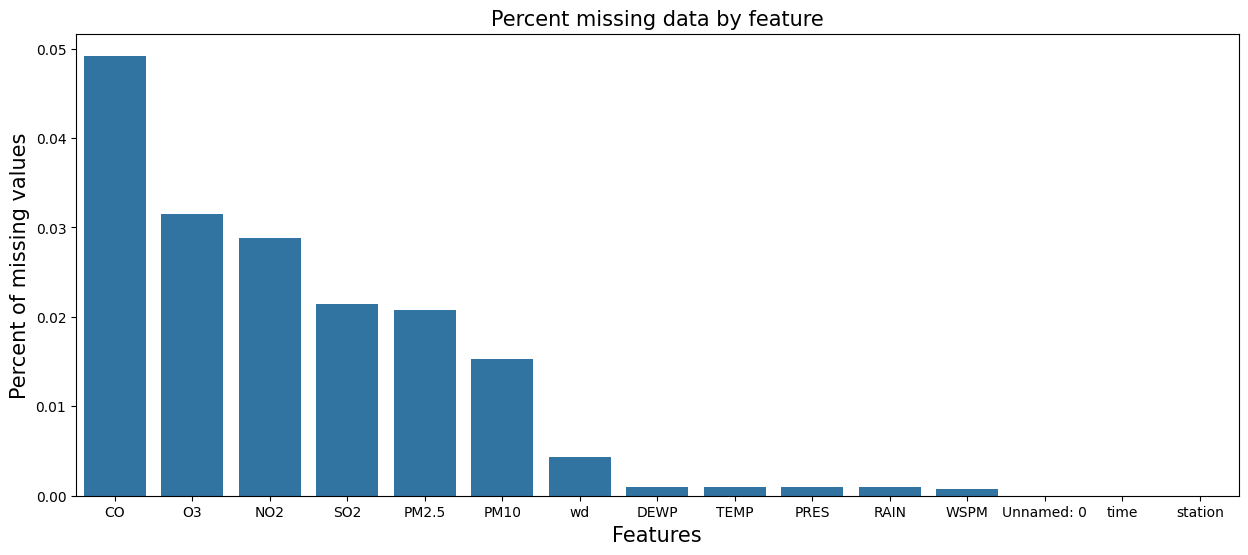

In [ ]:
print(missing_rate(dataset))
display_missing_percent(dataset)

In [ ]:
print(get_stat_by_station(dataset))

+-----+---------------+----------+-------------------------------+-------------------------------+
| No. |    station    | #Records |           From date           |            To date            |
+-----+---------------+----------+-------------------------------+-------------------------------+
|  1  |  Aotizhongxin |  35,064  | 2013-01-03T00:00:00.000000000 | 2017-02-28T23:00:00.000000000 |
|  1  |   Changping   |  35,064  | 2013-01-03T00:00:00.000000000 | 2017-02-28T23:00:00.000000000 |
|  1  |    Dingling   |  35,064  | 2013-01-03T00:00:00.000000000 | 2017-02-28T23:00:00.000000000 |
|  1  |     Dongsi    |  35,064  | 2013-01-03T00:00:00.000000000 | 2017-02-28T23:00:00.000000000 |
|  1  |    Guanyuan   |  35,064  | 2013-01-03T00:00:00.000000000 | 2017-02-28T23:00:00.000000000 |
|  1  |    Gucheng    |  35,064  | 2013-01-03T00:00:00.000000000 | 2017-02-28T23:00:00.000000000 |
|  1  |    Huairou    |  35,064  | 2013-01-03T00:00:00.000000000 | 2017-02-28T23:00:00.000000000 |
|  1  |  N

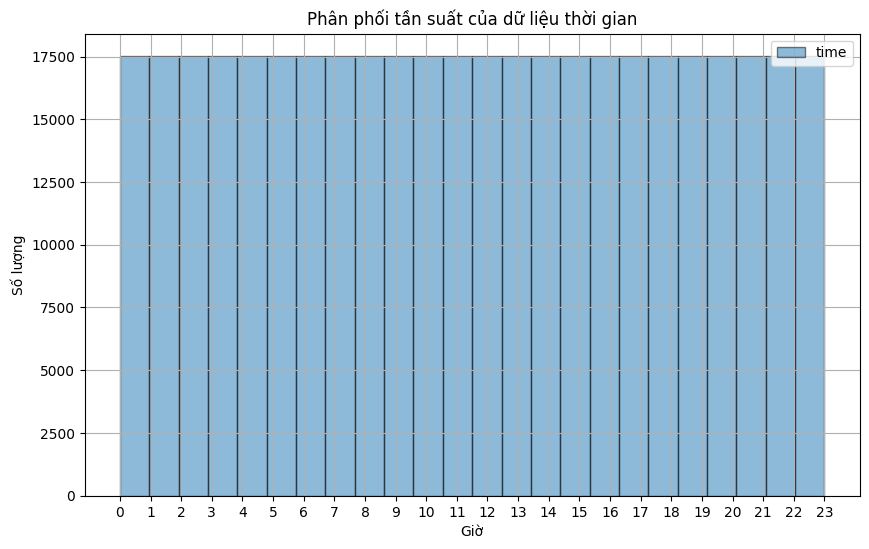

In [ ]:
datasets=[(dataset,'time')]
timeGraph(datasets)

In [ ]:
find_time_steps(dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Không có giờ nào thiếu.


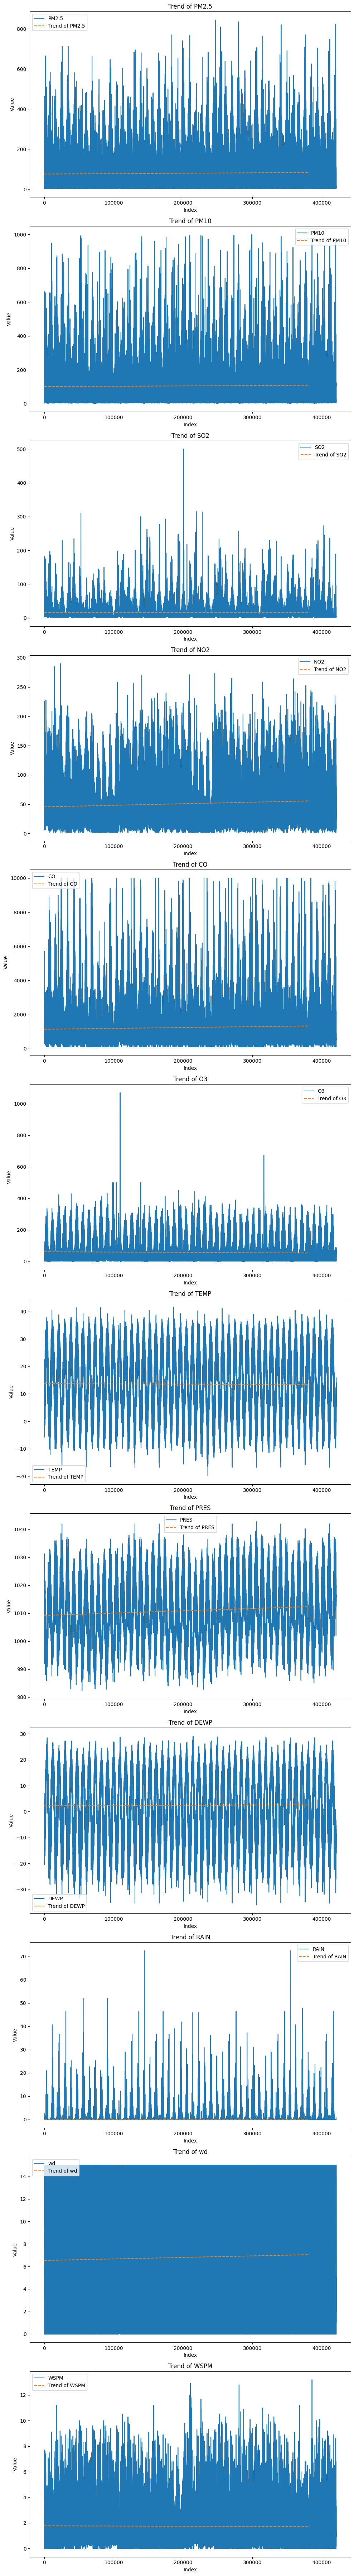

None


In [ ]:
trend=calculate_trend(dataset)
print(trend)

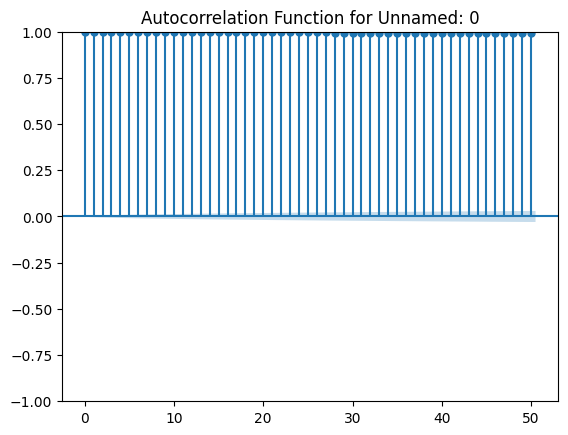

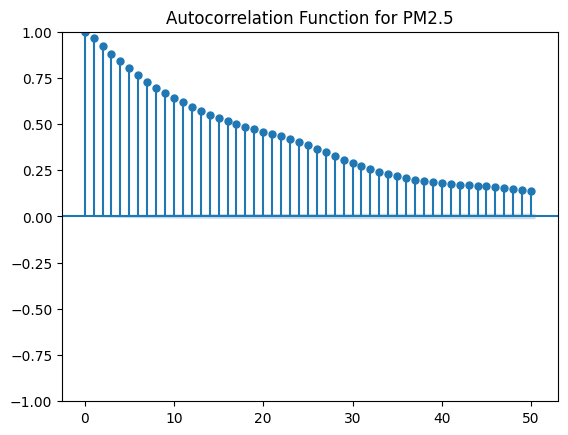

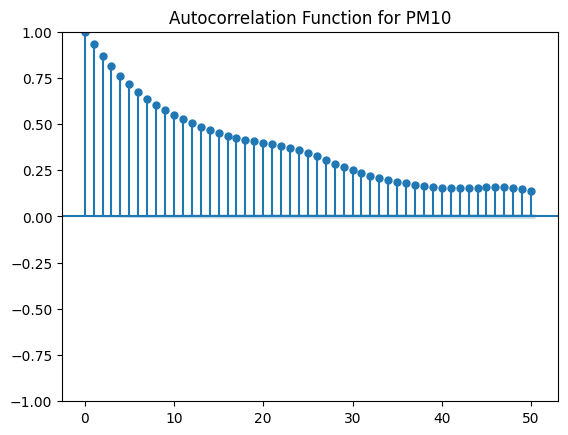

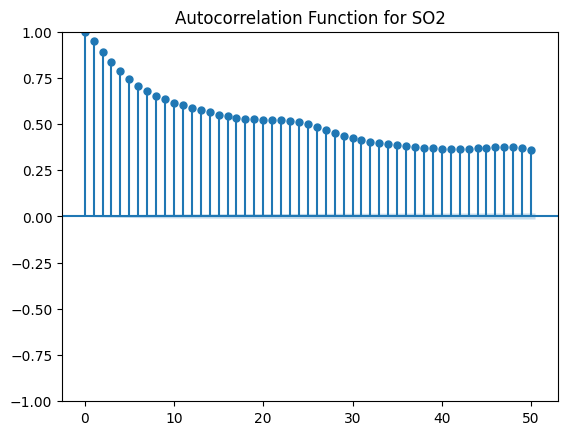

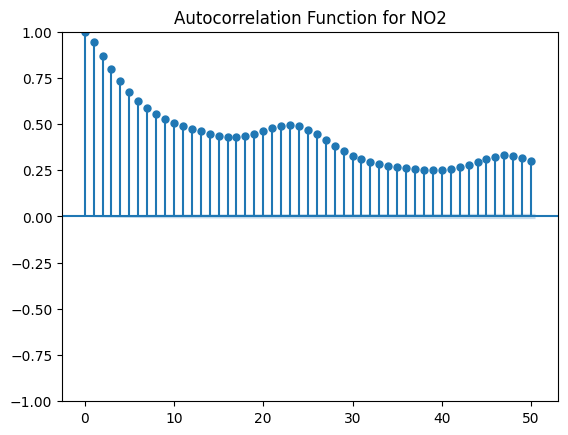

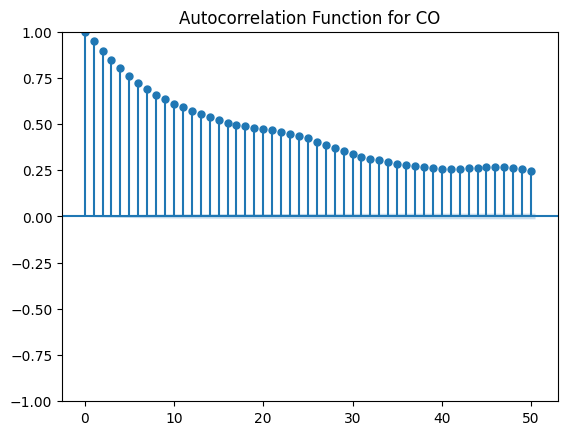

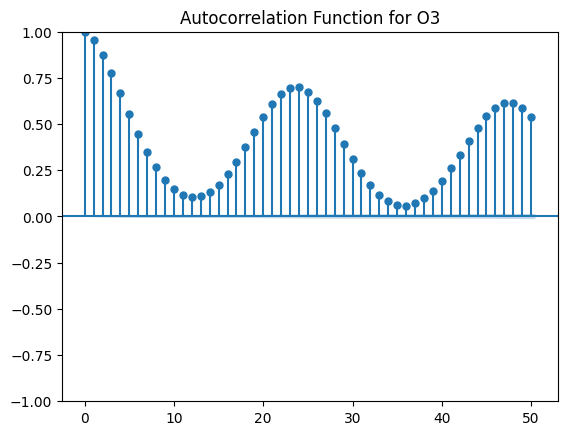

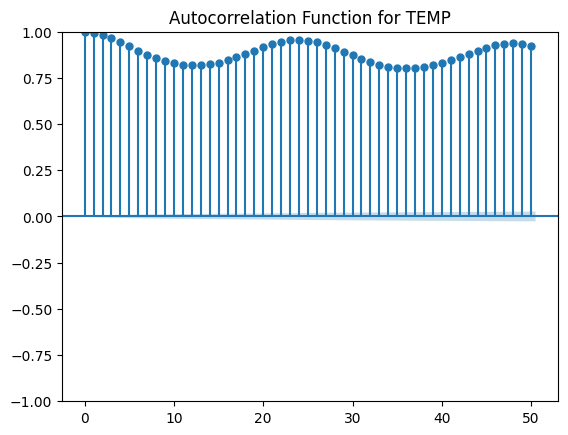

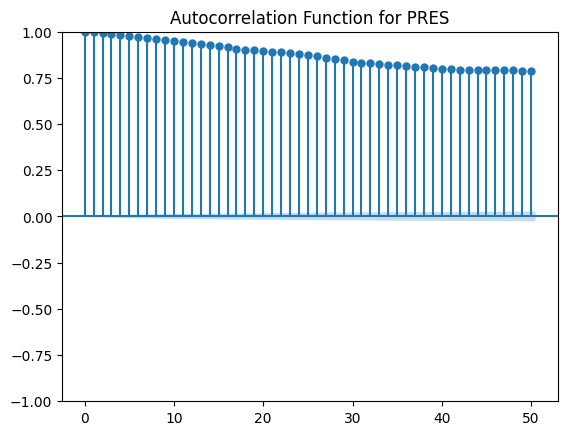

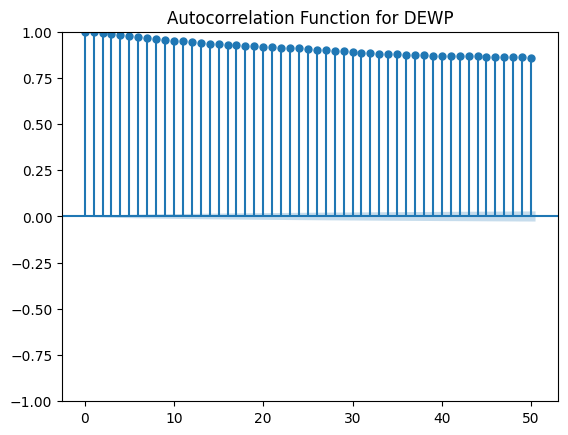

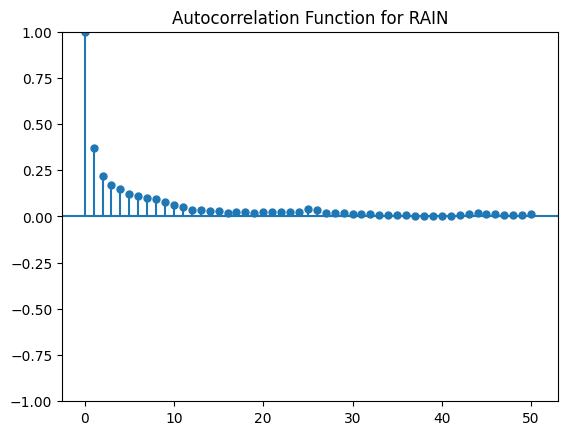

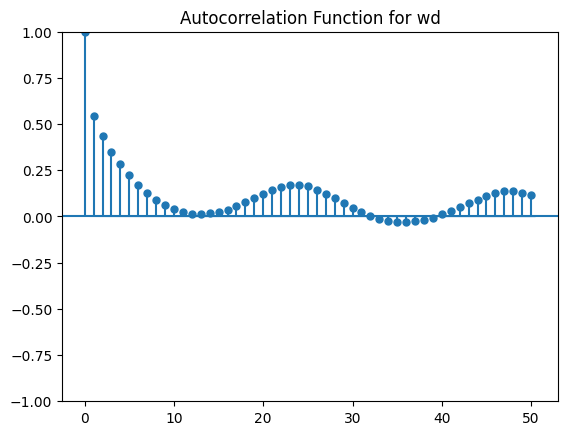

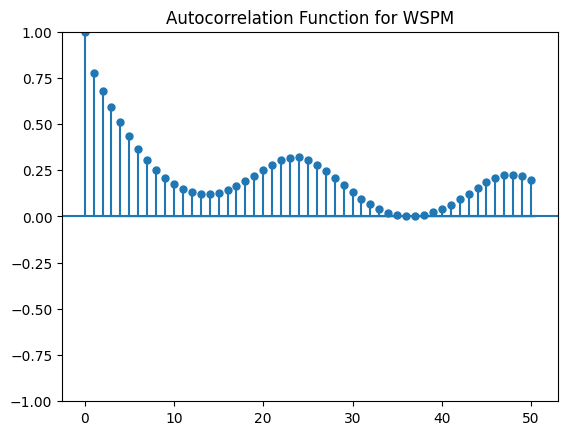

{'Unnamed: 0': 1,
 'PM2.5': 1,
 'PM10': 1,
 'SO2': 1,
 'NO2': 1,
 'CO': 1,
 'O3': 1,
 'TEMP': 1,
 'PRES': 1,
 'DEWP': 1,
 'RAIN': 1,
 'wd': 1,
 'WSPM': 1}

In [ ]:
find_cycles_for_all_columns(dataset)
# kết quả trả về cho thấy dữ liệu không có chu kỳ dài hạn rõ ràng trong phạm vi độ trễ được xem xét (ở đây là 50)

## Sau khi tiền xử lý

In [ ]:
pre_dataset=preprocess_beijing(dataset)
print(pre_dataset)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP (24, 17)
DF_TEMP 

In [36]:
n_steps = 24
# missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
missing_rates = [0.1]
methods = ['median','mean','knn', 'mice','saits','mrnn' ]



In [ ]:
df_mae, df_mse, df_rmse, df_running_time = run_experiment(pre_dataset, missing_rates, methods)

Rate: 0.1 Method: median N: 0
Rate: 0.1 Method: median N: 1
Rate: 0.1 Method: median N: 2
Rate: 0.1 Method: median N: 3
Rate: 0.1 Method: median N: 4
Rate: 0.1 Method: median N: 5
Rate: 0.1 Method: median N: 6
Rate: 0.1 Method: median N: 7
Rate: 0.1 Method: median N: 8
Rate: 0.1 Method: median N: 9
Rate: 0.1 Method: mean N: 0
Rate: 0.1 Method: mean N: 1
Rate: 0.1 Method: mean N: 2
Rate: 0.1 Method: mean N: 3
Rate: 0.1 Method: mean N: 4
Rate: 0.1 Method: mean N: 5
Rate: 0.1 Method: mean N: 6
Rate: 0.1 Method: mean N: 7
Rate: 0.1 Method: mean N: 8
Rate: 0.1 Method: mean N: 9
Rate: 0.1 Method: knn N: 0
Rate: 0.1 Method: knn N: 1
Rate: 0.1 Method: knn N: 2
Rate: 0.1 Method: knn N: 3
Rate: 0.1 Method: knn N: 4
Rate: 0.1 Method: knn N: 5
Rate: 0.1 Method: knn N: 6
Rate: 0.1 Method: knn N: 7
Rate: 0.1 Method: knn N: 8
Rate: 0.1 Method: knn N: 9
Rate: 0.1 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (9755, 312)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.0848661450

2024-05-31 06:30:51 [INFO]: Using the given device: cpu
2024-05-31 06:30:51 [INFO]: Model files will be saved to data/saits_beijing/20240531_T063051
2024-05-31 06:30:51 [INFO]: Tensorboard file will be saved to data/saits_beijing/20240531_T063051/tensorboard
2024-05-31 06:30:51 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,337,534


Rate: 0.1 Method: saits N: 0


2024-05-31 06:31:49 [INFO]: Epoch 001 - training loss: 0.6160, validation loss: 0.1132
2024-05-31 06:32:49 [INFO]: Epoch 002 - training loss: 0.3926, validation loss: 0.1025
2024-05-31 06:33:44 [INFO]: Epoch 003 - training loss: 0.3439, validation loss: 0.0982
2024-05-31 06:34:42 [INFO]: Epoch 004 - training loss: 0.3156, validation loss: 0.0967
2024-05-31 06:35:39 [INFO]: Epoch 005 - training loss: 0.3016, validation loss: 0.0946
2024-05-31 06:36:40 [INFO]: Epoch 006 - training loss: 0.2926, validation loss: 0.0935
2024-05-31 06:37:37 [INFO]: Epoch 007 - training loss: 0.2850, validation loss: 0.0930
2024-05-31 06:38:35 [INFO]: Epoch 008 - training loss: 0.2807, validation loss: 0.0954
2024-05-31 06:39:34 [INFO]: Epoch 009 - training loss: 0.2758, validation loss: 0.0917
2024-05-31 06:40:34 [INFO]: Epoch 010 - training loss: 0.2717, validation loss: 0.0909
2024-05-31 06:41:30 [INFO]: Epoch 011 - training loss: 0.2681, validation loss: 0.0883
2024-05-31 06:42:29 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 1


2024-05-31 06:46:35 [INFO]: Epoch 001 - training loss: 0.5709, validation loss: 0.1268
2024-05-31 06:47:32 [INFO]: Epoch 002 - training loss: 0.3986, validation loss: 0.1222
2024-05-31 06:48:33 [INFO]: Epoch 003 - training loss: 0.3568, validation loss: 0.1192
2024-05-31 06:49:31 [INFO]: Epoch 004 - training loss: 0.3351, validation loss: 0.1154
2024-05-31 06:50:29 [INFO]: Epoch 005 - training loss: 0.3215, validation loss: 0.1129
2024-05-31 06:51:26 [INFO]: Epoch 006 - training loss: 0.3081, validation loss: 0.1060
2024-05-31 06:52:24 [INFO]: Epoch 007 - training loss: 0.2999, validation loss: 0.1063
2024-05-31 06:53:25 [INFO]: Epoch 008 - training loss: 0.2959, validation loss: 0.1080
2024-05-31 06:54:24 [INFO]: Epoch 009 - training loss: 0.2900, validation loss: 0.1044
2024-05-31 06:55:21 [INFO]: Epoch 010 - training loss: 0.2844, validation loss: 0.1047
2024-05-31 06:56:18 [INFO]: Epoch 011 - training loss: 0.2797, validation loss: 0.1039
2024-05-31 06:57:18 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 2


2024-05-31 07:01:18 [INFO]: Epoch 001 - training loss: 0.5920, validation loss: 0.1125
2024-05-31 07:02:18 [INFO]: Epoch 002 - training loss: 0.3956, validation loss: 0.1063
2024-05-31 07:03:15 [INFO]: Epoch 003 - training loss: 0.3349, validation loss: 0.0990
2024-05-31 07:04:13 [INFO]: Epoch 004 - training loss: 0.3103, validation loss: 0.0967
2024-05-31 07:05:10 [INFO]: Epoch 005 - training loss: 0.2978, validation loss: 0.0985
2024-05-31 07:06:10 [INFO]: Epoch 006 - training loss: 0.2913, validation loss: 0.0975
2024-05-31 07:07:08 [INFO]: Epoch 007 - training loss: 0.2861, validation loss: 0.0940
2024-05-31 07:08:05 [INFO]: Epoch 008 - training loss: 0.2789, validation loss: 0.0945
2024-05-31 07:09:02 [INFO]: Epoch 009 - training loss: 0.2759, validation loss: 0.0934
2024-05-31 07:10:01 [INFO]: Epoch 010 - training loss: 0.2681, validation loss: 0.0948
2024-05-31 07:11:00 [INFO]: Epoch 011 - training loss: 0.2664, validation loss: 0.0977
2024-05-31 07:11:58 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 3


2024-05-31 07:13:06 [INFO]: Epoch 001 - training loss: 0.6009, validation loss: 0.1175
2024-05-31 07:14:05 [INFO]: Epoch 002 - training loss: 0.3867, validation loss: 0.1040
2024-05-31 07:15:04 [INFO]: Epoch 003 - training loss: 0.3415, validation loss: 0.0978
2024-05-31 07:16:02 [INFO]: Epoch 004 - training loss: 0.3184, validation loss: 0.0950
2024-05-31 07:17:01 [INFO]: Epoch 005 - training loss: 0.3058, validation loss: 0.0944
2024-05-31 07:17:59 [INFO]: Epoch 006 - training loss: 0.2975, validation loss: 0.0942
2024-05-31 07:18:59 [INFO]: Epoch 007 - training loss: 0.2894, validation loss: 0.0923
2024-05-31 07:19:58 [INFO]: Epoch 008 - training loss: 0.2849, validation loss: 0.0908
2024-05-31 07:20:56 [INFO]: Epoch 009 - training loss: 0.2792, validation loss: 0.0896
2024-05-31 07:21:53 [INFO]: Epoch 010 - training loss: 0.2755, validation loss: 0.0931
2024-05-31 07:22:51 [INFO]: Epoch 011 - training loss: 0.2728, validation loss: 0.0918
2024-05-31 07:23:52 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 4


2024-05-31 07:24:02 [INFO]: Tensorboard file will be saved to data/saits_beijing/20240531_T072402/tensorboard
2024-05-31 07:24:02 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,337,534
2024-05-31 07:24:58 [INFO]: Epoch 001 - training loss: 0.6035, validation loss: 0.1570
2024-05-31 07:25:56 [INFO]: Epoch 002 - training loss: 0.4046, validation loss: 0.1444
2024-05-31 07:26:55 [INFO]: Epoch 003 - training loss: 0.3580, validation loss: 0.1431
2024-05-31 07:27:54 [INFO]: Epoch 004 - training loss: 0.3324, validation loss: 0.1411
2024-05-31 07:28:51 [INFO]: Epoch 005 - training loss: 0.3098, validation loss: 0.1353
2024-05-31 07:29:49 [INFO]: Epoch 006 - training loss: 0.2969, validation loss: 0.1334
2024-05-31 07:30:47 [INFO]: Epoch 007 - training loss: 0.2903, validation loss: 0.1300
2024-05-31 07:31:43 [INFO]: Epoch 008 - training loss: 0.2843, validation loss: 0.1255
2024-05-31 07:32:43 [INFO]: Epoch 009 - training loss: 0.2804, validat

Rate: 0.1 Method: saits N: 5


2024-05-31 07:35:46 [INFO]: Epoch 001 - training loss: 0.6634, validation loss: 0.1176
2024-05-31 07:36:46 [INFO]: Epoch 002 - training loss: 0.4474, validation loss: 0.1019
2024-05-31 07:37:41 [INFO]: Epoch 003 - training loss: 0.3821, validation loss: 0.0921
2024-05-31 07:38:39 [INFO]: Epoch 004 - training loss: 0.3519, validation loss: 0.0925
2024-05-31 07:39:37 [INFO]: Epoch 005 - training loss: 0.3344, validation loss: 0.0929
2024-05-31 07:40:33 [INFO]: Epoch 006 - training loss: 0.3119, validation loss: 0.0882
2024-05-31 07:41:32 [INFO]: Epoch 007 - training loss: 0.2956, validation loss: 0.0891
2024-05-31 07:42:31 [INFO]: Epoch 008 - training loss: 0.2900, validation loss: 0.0912
2024-05-31 07:43:28 [INFO]: Epoch 009 - training loss: 0.2811, validation loss: 0.0862
2024-05-31 07:44:24 [INFO]: Epoch 010 - training loss: 0.2757, validation loss: 0.0888
2024-05-31 07:45:24 [INFO]: Epoch 011 - training loss: 0.2714, validation loss: 0.0914
2024-05-31 07:46:22 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 6


2024-05-31 07:46:32 [INFO]: Using the given device: cpu
2024-05-31 07:46:32 [INFO]: Model files will be saved to data/saits_beijing/20240531_T074632
2024-05-31 07:46:32 [INFO]: Tensorboard file will be saved to data/saits_beijing/20240531_T074632/tensorboard
2024-05-31 07:46:32 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,337,534
2024-05-31 07:47:30 [INFO]: Epoch 001 - training loss: 0.6517, validation loss: 0.1306
2024-05-31 07:48:28 [INFO]: Epoch 002 - training loss: 0.4222, validation loss: 0.1141
2024-05-31 07:49:25 [INFO]: Epoch 003 - training loss: 0.3699, validation loss: 0.1123
2024-05-31 07:50:24 [INFO]: Epoch 004 - training loss: 0.3445, validation loss: 0.1061
2024-05-31 07:51:22 [INFO]: Epoch 005 - training loss: 0.3261, validation loss: 0.1067
2024-05-31 07:52:21 [INFO]: Epoch 006 - training loss: 0.3152, validation loss: 0.1071
2024-05-31 07:53:17 [INFO]: Epoch 007 - training loss: 0.3078, validation loss: 0.1039
2024-05-

Rate: 0.1 Method: saits N: 7


2024-05-31 08:02:10 [INFO]: Epoch 001 - training loss: 0.6147, validation loss: 0.1744
2024-05-31 08:03:09 [INFO]: Epoch 002 - training loss: 0.3923, validation loss: 0.1653
2024-05-31 08:04:07 [INFO]: Epoch 003 - training loss: 0.3431, validation loss: 0.1603
2024-05-31 08:05:05 [INFO]: Epoch 004 - training loss: 0.3183, validation loss: 0.1525
2024-05-31 08:06:02 [INFO]: Epoch 005 - training loss: 0.3075, validation loss: 0.1628
2024-05-31 08:07:00 [INFO]: Epoch 006 - training loss: 0.2975, validation loss: 0.1542
2024-05-31 08:08:01 [INFO]: Epoch 007 - training loss: 0.2885, validation loss: 0.1534
2024-05-31 08:08:01 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-05-31 08:08:01 [INFO]: Finished training. The best model is from epoch#4.
2024-05-31 08:08:01 [INFO]: Saved the model to data/saits_beijing/20240531_T080112/SAITS.pypots
2024-05-31 08:08:10 [INFO]: Using the given device: cpu
2024-05-31 08:08:10 [INFO]: Model files will be saved to data/

Rate: 0.1 Method: saits N: 8


2024-05-31 08:09:08 [INFO]: Epoch 001 - training loss: 0.5989, validation loss: 0.1341
2024-05-31 08:10:06 [INFO]: Epoch 002 - training loss: 0.4094, validation loss: 0.1252
2024-05-31 08:11:03 [INFO]: Epoch 003 - training loss: 0.3564, validation loss: 0.1223
2024-05-31 08:12:03 [INFO]: Epoch 004 - training loss: 0.3258, validation loss: 0.1218
2024-05-31 08:13:02 [INFO]: Epoch 005 - training loss: 0.3055, validation loss: 0.1188
2024-05-31 08:13:58 [INFO]: Epoch 006 - training loss: 0.2949, validation loss: 0.1193
2024-05-31 08:14:56 [INFO]: Epoch 007 - training loss: 0.2878, validation loss: 0.1170
2024-05-31 08:15:55 [INFO]: Epoch 008 - training loss: 0.2807, validation loss: 0.1161
2024-05-31 08:16:56 [INFO]: Epoch 009 - training loss: 0.2769, validation loss: 0.1155
2024-05-31 08:17:52 [INFO]: Epoch 010 - training loss: 0.2738, validation loss: 0.1194
2024-05-31 08:18:50 [INFO]: Epoch 011 - training loss: 0.2689, validation loss: 0.1142
2024-05-31 08:19:48 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 9


2024-05-31 08:22:53 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,337,534
2024-05-31 08:23:49 [INFO]: Epoch 001 - training loss: 0.5908, validation loss: 0.1123
2024-05-31 08:24:48 [INFO]: Epoch 002 - training loss: 0.3896, validation loss: 0.0965
2024-05-31 08:25:47 [INFO]: Epoch 003 - training loss: 0.3452, validation loss: 0.0930
2024-05-31 08:26:44 [INFO]: Epoch 004 - training loss: 0.3215, validation loss: 0.0942
2024-05-31 08:27:41 [INFO]: Epoch 005 - training loss: 0.3085, validation loss: 0.0926
2024-05-31 08:28:40 [INFO]: Epoch 006 - training loss: 0.2986, validation loss: 0.0857
2024-05-31 08:29:38 [INFO]: Epoch 007 - training loss: 0.2895, validation loss: 0.0854
2024-05-31 08:30:36 [INFO]: Epoch 008 - training loss: 0.2834, validation loss: 0.0842
2024-05-31 08:31:34 [INFO]: Epoch 009 - training loss: 0.2767, validation loss: 0.0869
2024-05-31 08:32:31 [INFO]: Epoch 010 - training loss: 0.2724, validation loss: 0.0820
2024-0

Rate: 0.1 Method: mrnn N: 0


2024-05-31 08:35:35 [INFO]: Model files will be saved to data/mrnn_beijing/20240531_T083535
2024-05-31 08:35:35 [INFO]: Tensorboard file will be saved to data/mrnn_beijing/20240531_T083535/tensorboard
2024-05-31 08:35:35 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,103
2024-05-31 08:38:08 [INFO]: Epoch 001 - training loss: 1.1856, validation loss: 0.8163
2024-05-31 08:40:24 [INFO]: Epoch 002 - training loss: 0.9988, validation loss: 0.7698
2024-05-31 08:42:46 [INFO]: Epoch 003 - training loss: 0.9451, validation loss: 0.7385
2024-05-31 08:45:03 [INFO]: Epoch 004 - training loss: 0.9092, validation loss: 0.7165
2024-05-31 08:47:23 [INFO]: Epoch 005 - training loss: 0.8849, validation loss: 0.7056
2024-05-31 08:49:40 [INFO]: Epoch 006 - training loss: 0.8680, validation loss: 0.6985
2024-05-31 08:51:58 [INFO]: Epoch 007 - training loss: 0.8472, validation loss: 0.6935
2024-05-31 08:54:14 [INFO]: Epoch 008 - training loss: 0.8339, valida

Rate: 0.1 Method: mrnn N: 1


2024-05-31 09:06:11 [INFO]: Using the given device: cpu
2024-05-31 09:06:11 [INFO]: Model files will be saved to data/mrnn_beijing/20240531_T090611
2024-05-31 09:06:11 [INFO]: Tensorboard file will be saved to data/mrnn_beijing/20240531_T090611/tensorboard
2024-05-31 09:06:12 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,103
2024-05-31 09:08:44 [INFO]: Epoch 001 - training loss: 1.1912, validation loss: 0.8235
2024-05-31 09:11:00 [INFO]: Epoch 002 - training loss: 1.0069, validation loss: 0.7766
2024-05-31 09:13:20 [INFO]: Epoch 003 - training loss: 0.9483, validation loss: 0.7432
2024-05-31 09:15:36 [INFO]: Epoch 004 - training loss: 0.9143, validation loss: 0.7240
2024-05-31 09:17:54 [INFO]: Epoch 005 - training loss: 0.8879, validation loss: 0.7066
2024-05-31 09:20:11 [INFO]: Epoch 006 - training loss: 0.8667, validation loss: 0.6975
2024-05-31 09:22:30 [INFO]: Epoch 007 - training loss: 0.8542, validation loss: 0.6886
2024-05-31 09

Rate: 0.1 Method: mrnn N: 2


2024-05-31 09:43:57 [INFO]: Epoch 001 - training loss: 1.1862, validation loss: 0.8264
2024-05-31 09:46:12 [INFO]: Epoch 002 - training loss: 1.0049, validation loss: 0.7857
2024-05-31 09:48:30 [INFO]: Epoch 003 - training loss: 0.9491, validation loss: 0.7611
2024-05-31 09:50:45 [INFO]: Epoch 004 - training loss: 0.9147, validation loss: 0.7480
2024-05-31 09:53:04 [INFO]: Epoch 005 - training loss: 0.8902, validation loss: 0.7398
2024-05-31 09:55:18 [INFO]: Epoch 006 - training loss: 0.8713, validation loss: 0.7284
2024-05-31 09:57:36 [INFO]: Epoch 007 - training loss: 0.8548, validation loss: 0.7127
2024-05-31 09:59:55 [INFO]: Epoch 008 - training loss: 0.8403, validation loss: 0.7054
2024-05-31 10:02:10 [INFO]: Epoch 009 - training loss: 0.8280, validation loss: 0.7029
2024-05-31 10:04:29 [INFO]: Epoch 010 - training loss: 0.8226, validation loss: 0.7021
2024-05-31 10:06:44 [INFO]: Epoch 011 - training loss: 0.8139, validation loss: 0.7028
2024-05-31 10:09:02 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 3


2024-05-31 10:14:18 [INFO]: Epoch 001 - training loss: 1.1795, validation loss: 0.8253
2024-05-31 10:16:36 [INFO]: Epoch 002 - training loss: 0.9912, validation loss: 0.7724
2024-05-31 10:18:52 [INFO]: Epoch 003 - training loss: 0.9374, validation loss: 0.7410
2024-05-31 10:21:12 [INFO]: Epoch 004 - training loss: 0.9092, validation loss: 0.7235
2024-05-31 10:23:28 [INFO]: Epoch 005 - training loss: 0.8789, validation loss: 0.7165
2024-05-31 10:25:45 [INFO]: Epoch 006 - training loss: 0.8609, validation loss: 0.7071
2024-05-31 10:28:02 [INFO]: Epoch 007 - training loss: 0.8444, validation loss: 0.7000
2024-05-31 10:30:21 [INFO]: Epoch 008 - training loss: 0.8358, validation loss: 0.6956
2024-05-31 10:32:37 [INFO]: Epoch 009 - training loss: 0.8266, validation loss: 0.6954
2024-05-31 10:34:55 [INFO]: Epoch 010 - training loss: 0.8167, validation loss: 0.6940
2024-05-31 10:37:14 [INFO]: Epoch 011 - training loss: 0.8117, validation loss: 0.6930
2024-05-31 10:39:30 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 4


2024-05-31 10:47:05 [INFO]: Epoch 001 - training loss: 1.1897, validation loss: 0.8346
2024-05-31 10:49:26 [INFO]: Epoch 002 - training loss: 0.9936, validation loss: 0.7882
2024-05-31 10:51:43 [INFO]: Epoch 003 - training loss: 0.9379, validation loss: 0.7578
2024-05-31 10:54:01 [INFO]: Epoch 004 - training loss: 0.9079, validation loss: 0.7357
2024-05-31 10:56:18 [INFO]: Epoch 005 - training loss: 0.8878, validation loss: 0.7174
2024-05-31 10:58:38 [INFO]: Epoch 006 - training loss: 0.8687, validation loss: 0.7114
2024-05-31 11:00:55 [INFO]: Epoch 007 - training loss: 0.8556, validation loss: 0.7046
2024-05-31 11:03:13 [INFO]: Epoch 008 - training loss: 0.8377, validation loss: 0.7033
2024-05-31 11:05:32 [INFO]: Epoch 009 - training loss: 0.8268, validation loss: 0.7008
2024-05-31 11:07:49 [INFO]: Epoch 010 - training loss: 0.8192, validation loss: 0.7009
2024-05-31 11:10:08 [INFO]: Epoch 011 - training loss: 0.8145, validation loss: 0.7004
2024-05-31 11:12:25 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 5


2024-05-31 11:17:31 [INFO]: MRNN initialized with the given hyperparameters, the number of trainable parameters: 103,103
